In [296]:
### import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
from astropy.io import fits
import os
from joblib import Parallel, delayed
import warnings

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

from scipy.ndimage import gaussian_filter

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [4]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [5]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

# check orbit of subhalo

In [99]:
sd = 0
key = 'lvl4-sd'+str(sd)
output_dir = basepath + 'runs/MW7_GSE4-Rs142-Vv116-ecc04-lvl4/' + key + '/output'
    
time = np.zeros_like(np.arange(0, 321), dtype=float)
subpos0 = np.zeros((321, 3), dtype=float)
subpos1 = np.zeros((321, 3), dtype=float)
sfr0 = np.zeros(321, dtype=float)
for idx in tqdm(range(321)):
    subfname = output_dir + '/fof_subhalo_tab_'+str(idx).zfill(3)+'.hdf5'
    sub = h5.File(subfname, mode='r')
    subpos0[idx] = sub['Subhalo/SubhaloPos'][0]
    if len(sub['Subhalo/SubhaloPos']) > 1:
        subpos1[idx] = sub['Subhalo/SubhaloPos'][1]
    else:
        subpos1[idx] = np.array([np.nan, np.nan, np.nan])
    time[idx] = sub['Header'].attrs['Time']
    sfr0[idx] = sub['Subhalo/SubhaloSFR'][0]
    sub.close()

100%|██████████| 321/321 [00:00<00:00, 616.62it/s]


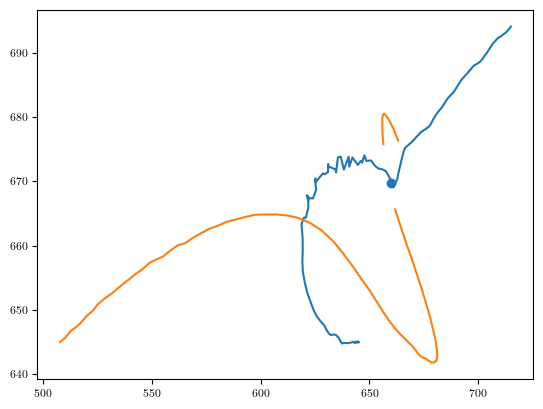

In [90]:
# key = np.logical_and(time > 2, time < 3.5)
key = time < 4
ip = 80
l0 = plt.plot(subpos0[key, 0], subpos0[key, 1])
l1 = plt.plot(subpos1[key, 0], subpos1[key, 1])
plt.scatter(subpos0[ip, 0], subpos0[ip, 1], c=l0[0].get_color())
plt.scatter(subpos1[ip, 0], subpos1[ip, 1], c=l1[0].get_color())
# plt.xlim(

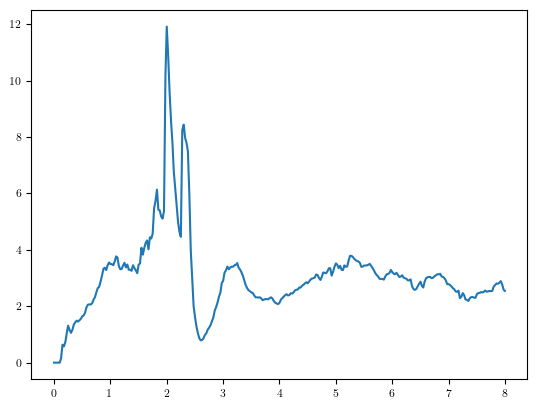

In [100]:
plt.plot(time, sfr0)

In [98]:
idx = 81
subfname = output_dir + '/fof_subhalo_tab_'+str(idx).zfill(3)+'.hdf5'
sub = h5.File(subfname, mode='r')
print(sub['Subhalo/SubhaloSFR'][:])

sub.close()

[10.862082    0.47179952]


In [100]:

def sum_sfr0_in_bins(logFeH, logMgFe, sfr0, logFeH0=0, dlogFeH=0.4, logMgFe_bins=np.arange(0.1, 0.6, 0.05)):
    """
    Function to sum sfr0 values within bins of logMgFe, after selecting entries with logFeH within a specific range.

    Parameters:
    - logFeH: array of log[Fe/H] values
    - logMgFe: array of log[Mg/Fe] values
    - sfr0: array of sfr0 values
    - logFeH0: center of logFeH bin (default: 0)
    - dlogFeH: width of logFeH bin (default: 0.4)
    - logMgFe_bins: bin edges for logMgFe (default: np.arange(0.1, 0.6, 0.05))

    Returns:
    - sfr0_sums: List of the sum of sfr0 values for each logMgFe bin
    """
    # Select entries with logFeH fitting within the bin centered at logFeH0 with width dlogFeH
    logFeH_bin_mask = (logFeH >= logFeH0 - dlogFeH / 2) & (logFeH <= logFeH0 + dlogFeH / 2)
    
    # Apply the mask to logFeH, logMgFe, and sfr0
    filtered_logFeH = logFeH[logFeH_bin_mask]
    filtered_logMgFe = logMgFe[logFeH_bin_mask]
    filtered_sfr0 = sfr0[logFeH_bin_mask]

    # Use np.digitize to find bin indices for logMgFe
    bin_indices = np.digitize(filtered_logMgFe, logMgFe_bins) - 1  # -1 to make bin indices zero-based

    # Mask out any entries that fall outside the desired range of bins (logMgFe_bins)
    valid_bin_mask = (bin_indices >= 0) & (bin_indices < len(logMgFe_bins) - 1)
    filtered_sfr0 = filtered_sfr0[valid_bin_mask]
    bin_indices = bin_indices[valid_bin_mask]

    # Sum sfr0 for each bin using np.bincount
    sfr0_sums = np.bincount(bin_indices, weights=filtered_sfr0, minlength=len(logMgFe_bins) - 1)

    return sfr0_sums

def get_summary(idx, sd, rmin=2, rmax=5, dsnap=0.025, rgal=15):
    out = {}
    key = 'lvl4-sd'+str(sd)
    output_dir = basepath + 'runs/MW7_GSE4-Rs142-Vv116-ecc04-lvl4/' + key + '/output'
    
    subfname = output_dir + '/fof_subhalo_tab_'+str(idx).zfill(3)+'.hdf5'
    if not os.path.exists(subfname):
        return out
    
    sub = h5.File(subfname, mode='r')
    sub0pos = sub['Subhalo/SubhaloPos'][0]
    sub.close()
    
    

    snap = h5.File(output_dir + '/snapshot_'+str(idx).zfill(3)+'.hdf5', mode='r')
    NumPart_Total = snap['Header'].attrs['NumPart_Total']
    Time = snap['Header'].attrs['Time']
    out['Time'] = Time
    
    if NumPart_Total[4] > 0:
        pos4 = snap['PartType4/Coordinates'][:]
        r4 = np.linalg.norm(pos4 - sub0pos, axis=1)
        is_star_in_SN = np.logical_and(r4 > rmin, r4 < rmax)
        age4 = snap['PartType4/GFM_StellarFormationTime'][:]
        is_star_in_SN = np.logical_and(is_star_in_SN, age4 > 0)
        
        is_star_in_gal = np.logical_and(age4 > 0, r4 < rgal)
        
        is_in_agebin = np.logical_and(age4 <= Time, age4 > Time - dsnap)
        
        mass4 = snap['PartType4/Masses'][:]
        
        metals4 = snap['PartType4/GFM_Metals'][:]
        FeH4 = metals4[:,8] / GFM_SOLAR_ABUNDANCE_IRON
        MgH4 = metals4[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
        
        logFeH4 = np.log10(FeH4)
        logMgH4 = np.log10(MgH4)
        logMgFe4 = logMgH4 - logFeH4
        
        out['Mstar'] = np.sum(mass4[is_star_in_SN])
        out['globalMstar'] = np.sum(mass4[is_star_in_gal])
        
        key = np.logical_and(is_star_in_SN, is_in_agebin)
        out['dMstar'] = np.sum(mass4[key])
    else:
        out['Mstar'] = 0.0
        out['dMstar'] = 0.0
        out['globalMstar'] = 0.0
    
    mass0 = snap['PartType0/Masses'][:]
    sfr0 = snap['PartType0/StarFormationRate'][:]
    
    pos0 = snap['PartType0/Coordinates'][:]
    r0 = np.linalg.norm(pos0 - sub0pos, axis=1)
    in_SN = np.logical_and(r0 > rmin, r0 < rmax)
    in_gal = r0 < rgal
    
    metals0 = snap['PartType0/GFM_Metals'][:]
    FeH = metals0[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = metals0[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH
    
    out['BH_Mdot'] = snap['PartType5/BH_Mdot'][0]
    out['BH_CumEgyInjection_QM'] = snap['PartType5/BH_CumEgyInjection_QM'][0]
    out['BH_CumEgyInjection_RM'] = snap['PartType5/BH_CumEgyInjection_RM'][0]
    out['BH_MdotEddington'] = snap['PartType5/BH_MdotEddington'][0]
    out['BH_Mass'] = snap['PartType5/Masses'][0]
    
    out['Mgas'] = np.sum(mass0[in_SN])
    out['SFR'] = np.sum(sfr0[in_SN])
    
    out['globalSFR'] = np.sum(sfr0[in_gal])
    out['globalMgas'] = np.sum(mass0[in_gal])
    
    out['simSFR'] = np.sum(sfr0)
    
    dlogFeH = 0.1
    logFeH0_list = np.arange(-1, 0.5+0.1, 0.1)
    Mgas_inFeHbin = np.zeros_like(logFeH0_list)
    SFR_inFeHbin = np.zeros_like(logFeH0_list)
    medalpha_inFeHbin = np.zeros_like(logFeH0_list)
    hiperc_alpha_inFeHbin = np.zeros_like(logFeH0_list)
    loperc_alpha_inFeHbin = np.zeros_like(logFeH0_list)
    for i,logFeH0 in enumerate(logFeH0_list):
        key = np.logical_and(logFeH - logFeH0 < dlogFeH/2., logFeH - logFeH0 > -dlogFeH/2)
        key = np.logical_and(key, in_SN)
        
        Mgas_inFeHbin[i] = np.sum(mass0[key])
        SFR_inFeHbin[i] = np.sum(sfr0[key])
        # with warnings.catch_warnings():
            # warnings.simplefilter("ignore", category=RuntimeWarning)
        if True:
            if np.sum(key) < 30:
                medalpha_inFeHbin[i] = hiperc_alpha_inFeHbin[i] = loperc_alpha_inFeHbin[i] = np.nan
            else:
                medalpha_inFeHbin[i] = np.median(logMgFe[key])
                hiperc_alpha_inFeHbin[i] = np.percentile(logMgFe[key], 50 + 68/2)
                loperc_alpha_inFeHbin[i] = np.percentile(logMgFe[key], 50 - 68/2)
            
    
    out['Mgas_inFeHbin'] = Mgas_inFeHbin
    out['SFR_inFeHbin'] = SFR_inFeHbin
    out['medalpha_inFeHbin'] = medalpha_inFeHbin
    out['hiperc_alpha_inFeHbin'] = hiperc_alpha_inFeHbin
    out['loperc_alpha_inFeHbin'] = loperc_alpha_inFeHbin
    
    # now do sfr in alpha bin with big feh bin
    logFeH0 = 0
    dlogFeH = 0.4
    
    out['sfr_in_MgFe_bins'] = sum_sfr0_in_bins(logFeH[in_SN], logMgFe[in_SN], sfr0[in_SN])
    
    snap.close()
    
    return out

In [19]:
logFeH0_list = np.arange(-1, 0.5+0.1, 0.1)
print(logFeH0_list[10])

-2.220446049250313e-16


In [9]:
def get_dat_summary(sd, rmin=2, rmax=5, use_tqdm=False):

    if use_tqdm:
        itr = tqdm(np.arange(320+1), position=0, leave=True)
    else:
        itr = np.arange(320+1)
    
    outs = Parallel(n_jobs=64) (delayed(get_summary)(idx, sd, rmin=rmin, rmax=rmax) 
                                for idx in itr)

    dat = {}
    for k in outs[0].keys():
        dat[k] = []

    for out in outs:
        for k in dat.keys():
            if k in out.keys():
                dat[k].append(out[k])
    
    for k in dat.keys():
        dat[k] = np.array(dat[k])

    return dat

In [99]:
for i in range(321):
    get_summary(i, 0)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2330 but corresponding boolean dimension is 2328

In [101]:
a = get_dat_summary(0, use_tqdm=True)

100%|██████████| 321/321 [00:04<00:00, 76.85it/s]


In [102]:
alldat = {}
for sd in tqdm(np.arange(16), position=0, leave=True):
    alldat[sd] = get_dat_summary(sd)

100%|██████████| 16/16 [01:26<00:00,  5.43s/it]


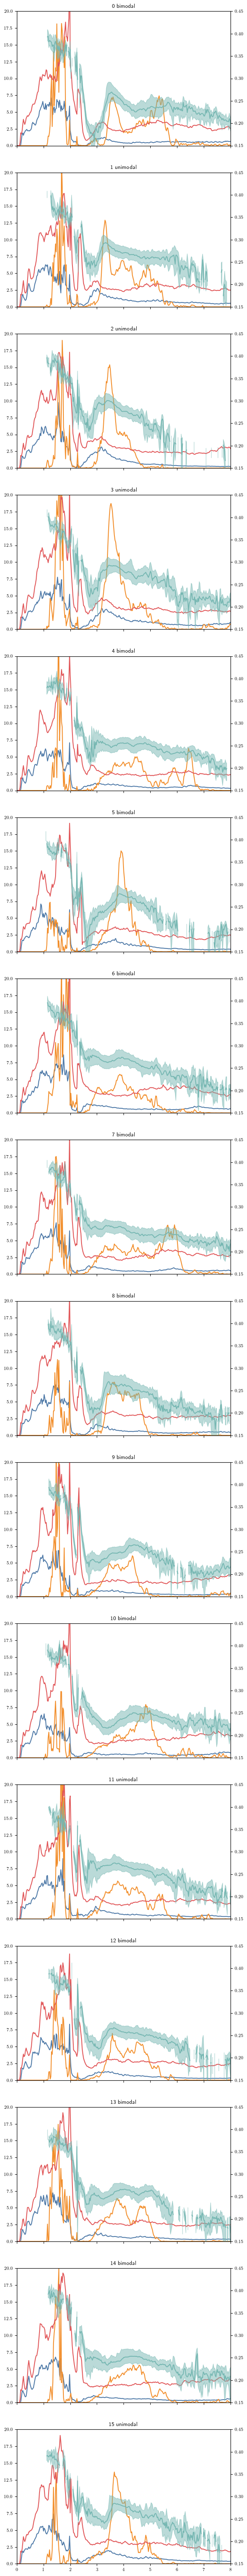

In [57]:
fig, axs = plt.subplots(16, 1, figsize=(2*columnwidth, 2*12*columnwidth), sharex=True, sharey=True)

i_Fe = 10

# this is based on plots w/ fiducial sfr
# has_bimodal = [0, 4, 7, 12, 13, 14]
# sfr_fac = 1

# this is based on plots w/ enhanced sfr
has_bimodal = [0, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]
sfr_fac = 3

for i in alldat.keys():
    
    glob_sfr = np.copy(alldat[i]['globalSFR'])
    glob_sfr[alldat[i]['Time'] < 2] *= sfr_fac
    
    sfr = np.copy(alldat[i]['SFR'])
    sfr[alldat[i]['Time'] < 2] *= sfr_fac
    
    sfr_inbin = alldat[i]['SFR_inFeHbin'][:,i_Fe]/0.05
    sfr_inbin[alldat[i]['Time'] < 2] *= sfr_fac
    
    axs[i].plot(alldat[i]['Time'], sfr, c=tb_c[0])
    # axs[i].plot(alldat[i]['Time'], alldat[i]['Mgas']/alldat[i]['SFR'], c=tb_c[2])
    axs[i].plot(alldat[i]['Time'], sfr_inbin, c=tb_c[1])
    axs[i].plot(alldat[i]['Time'], glob_sfr, c=tb_c[2])
    
    ax2 = axs[i].twinx()
    ax2.set(ylim=(0.15, 0.45))
    
    ax2.plot(alldat[i]['Time'], alldat[i]['medalpha_inFeHbin'][:,i_Fe], c=tb_c[3])
    ax2.fill_between(alldat[i]['Time'], alldat[i]['loperc_alpha_inFeHbin'][:,i_Fe], 
                     alldat[i]['hiperc_alpha_inFeHbin'][:,i_Fe], color=tb_c[3], alpha=0.5)
    
    if i in has_bimodal:
        axs[i].set_title(str(i)+' bimodal')
    else:
        axs[i].set_title(str(i)+' unimodal')        
    
axs[0].set(xlim=(0, 8), ylim=(0, 20))
fig.savefig('sfh_stuff.pdf')
fig.savefig('sfh_stuff2.pdf')

In [64]:
alldat[0].keys()

dict_keys(['Time', 'Mstar', 'dMstar', 'globalMstar', 'BH_Mdot', 'BH_CumEgyInjection_QM', 'BH_CumEgyInjection_RM', 'BH_MdotEddington', 'BH_Mass', 'Mgas', 'SFR', 'globalSFR', 'globalMgas', 'simSFR', 'Mgas_inFeHbin', 'SFR_inFeHbin', 'medalpha_inFeHbin', 'hiperc_alpha_inFeHbin', 'loperc_alpha_inFeHbin'])

In [80]:
19411369027965/1e13

1.9411369027965

(0.0, 250.0)
(0.0, 250.0)
(0.0, 250.0)
(0.0, 250.0)
(0.0, 250.0)
(0.0, 250.0)
(0.0, 250.0)
(0.0, 250.0)
(0.0, 250.0)
(0.0, 250.0)
(0.0, 250.0)
(0.0, 250.0)
(0.0, 250.0)
(0.0, 250.0)
(0.0, 250.0)
(0.0, 250.0)


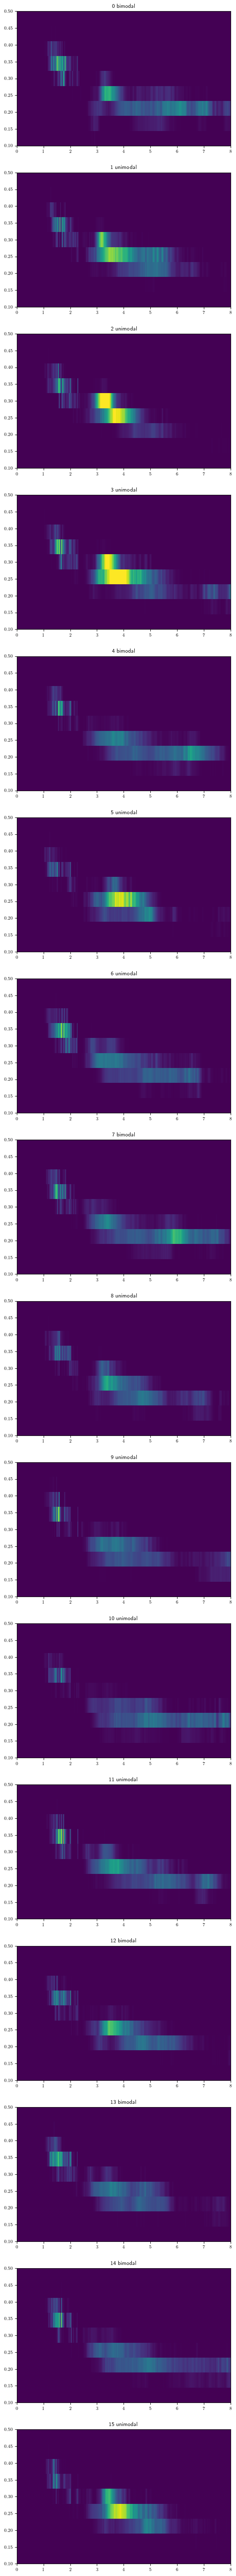

In [104]:
fig, axs = plt.subplots(16, 1, figsize=(2*columnwidth, 2*12*columnwidth))

# this is based on plots w/ fiducial sfr
has_bimodal = [0, 4, 7, 12, 13, 14]
sfr_fac = 1

# this is based on plots w/ enhanced sfr
# has_bimodal = [0, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]
# sfr_fac = 3

for i in range(16):
    ax = axs[i]
    key = alldat[i]['Time'] < 2
    hmap = np.copy(alldat[i]['sfr_in_MgFe_bins'])
    hmap[key,:] *= sfr_fac
    
    dt = 8 / hmap.shape[0]
    dfe = 1.5 / hmap.shape[1]
    hmap /= dt*dfe
    
    im = ax.imshow(hmap.T, origin='lower', extent=[0, 8, 0.1, 0.5], vmin=0, vmax=250, interpolation='none')
    ax.set_aspect('auto')
    print(im.get_clim())
    
    if i in has_bimodal:
        ax.set_title(str(i) + ' bimodal')
    else:
        ax.set_title(str(i) + ' unimodal')

[(0.15, 0.45)]

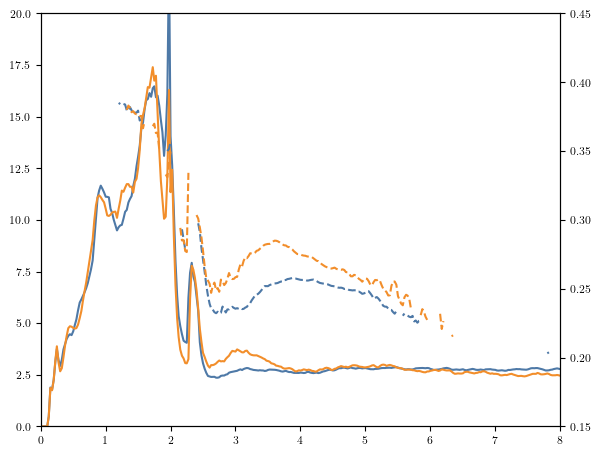

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(2*columnwidth, 2*0.8*columnwidth), sharex=True, sharey=True)

i_Fe = 10

# this is based on plots w/ fiducial sfr
# has_bimodal = [0, 4, 7, 12, 13, 14]
# sfr_fac = 1

# this is based on plots w/ enhanced sfr
has_bimodal = [0, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]
sfr_fac = 3

bimodal_aveT = np.zeros_like(alldat[0]['Time'])
bimodal_avealpha = np.zeros_like(alldat[0]['medalpha_inFeHbin'][:,i_Fe])
bimodal_aveSFR = np.zeros_like(alldat[0]['globalSFR'])
bimodal_N = 0

unimodal_aveT = np.zeros_like(alldat[0]['Time'])
unimodal_avealpha = np.zeros_like(alldat[0]['medalpha_inFeHbin'][:,i_Fe])
unimodal_aveSFR = np.zeros_like(alldat[0]['globalSFR'])
unimodal_N = 0

for i in alldat.keys():
    if i in has_bimodal:
        bimodal_aveT += alldat[i]['Time']
        bimodal_avealpha += alldat[i]['medalpha_inFeHbin'][:,i_Fe]
        bimodal_aveSFR += alldat[i]['globalSFR']
        bimodal_N += 1
    else:
        unimodal_aveT += alldat[i]['Time']
        unimodal_avealpha += alldat[i]['medalpha_inFeHbin'][:,i_Fe]
        unimodal_aveSFR += alldat[i]['globalSFR']
        unimodal_N += 1

bimodal_aveT /= bimodal_N
bimodal_avealpha /= bimodal_N
bimodal_aveSFR /= bimodal_N
unimodal_aveT /= unimodal_N
unimodal_avealpha /= unimodal_N
unimodal_aveSFR /= unimodal_N

bimodal_aveSFR[bimodal_aveT < 2] *= sfr_fac
unimodal_aveSFR[unimodal_aveT < 2] *= sfr_fac
    
# ax.plot(alldat[i]['Time'], alldat[i]['medalpha_inFeHbin'][:,i_Fe], c=c, alpha=0.5)
ax.plot(bimodal_aveT, bimodal_aveSFR, c=tb_c[0])
ax.plot(unimodal_aveT, unimodal_aveSFR, c=tb_c[1])

ax2 = ax.twinx()
ax2.plot(bimodal_aveT, bimodal_avealpha, c=tb_c[0], ls='dashed')
ax2.plot(unimodal_aveT, unimodal_avealpha, c=tb_c[1], ls='dashed')

ax.set(xlim=(0, 8), ylim=(0, 20))
ax2.set(ylim=(0.15, 0.45))

0 bimodal 0.7903049
1 unimodal 2.3002899
2 unimodal 2.4604259
3 unimodal 2.3047347
4 bimodal 2.281882
5 unimodal 1.0767243
6 unimodal 2.499502
7 bimodal 2.048538
8 unimodal 1.5879766
9 unimodal 1.7564064
10 unimodal 2.068074
11 unimodal 1.980989
12 bimodal 1.7981534
13 bimodal 2.4992702
14 bimodal 2.321102
15 unimodal 2.8110387


(array([0., 0., 0., 0., 1., 0., 1., 2., 1., 4., 0., 1.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  ]),
 [<matplotlib.patches.Polygon at 0x151881881db0>])

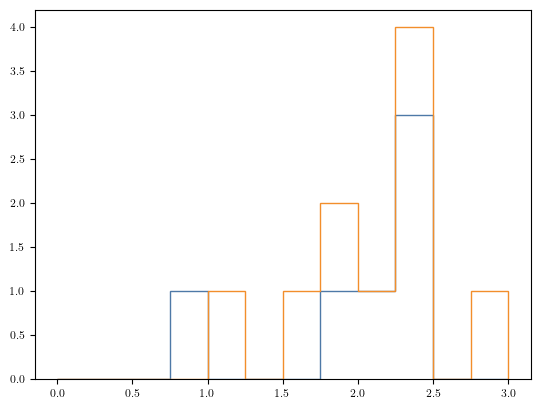

In [65]:
minSFR_bimodal = []
minSFR_unimodal = []
for i in alldat.keys():
    key = np.logical_and(alldat[i]['Time'] > 2, alldat[i]['Time'] < 4)
    if i in has_bimodal:
        print(i, 'bimodal', np.min(alldat[i]['globalSFR'][key]))
        minSFR_bimodal.append(np.min(alldat[i]['globalSFR'][key]))
    else:
        print(i, 'unimodal', np.min(alldat[i]['globalSFR'][key]))
        minSFR_unimodal.append(np.min(alldat[i]['globalSFR'][key]))
        
plt.hist(minSFR_bimodal, bins=np.arange(0, 3+0.25, 0.25), histtype='step', color=tb_c[0])
plt.hist(minSFR_unimodal, bins=np.arange(0, 3+0.25, 0.25), histtype='step', color=tb_c[1])

In [41]:
alldat[0].keys()

dict_keys(['Time', 'Mstar', 'dMstar', 'globalMstar', 'BH_Mdot', 'BH_CumEgyInjection_QM', 'BH_CumEgyInjection_RM', 'BH_MdotEddington', 'BH_Mass', 'Mgas', 'SFR', 'globalSFR', 'globalMgas', 'Mgas_inFeHbin', 'SFR_inFeHbin', 'medalpha_inFeHbin'])

### figure 1

In [297]:
def load_galaxy(sd, idx=320):
    key = 'lvl4-sd'+str(sd)
    return galaxy.Galaxy(basepath + 'runs/MW7_GSE4-Rs142-Vv116-ecc04-lvl4/' + key + '/output',
                                              idx, orient=True)

def extract_sim_data(gal, no_SN=False):
    sn = gal.sn
    
    ### get logFeH and logMgFe ###
    FeH = sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH

    ### get in_SN ###
    Lzsun = 8 * 220 * 0.2
    zmax = 3
    dLz = 0.3
    
    Lz = np.cross(sn.part4.rotpos, sn.part4.rotvel)[:,2]
    in_SN = np.logical_and(np.abs((Lz/Lzsun)-1) < dLz, np.abs(sn.part4.rotpos[:,2]) < zmax)
    
    if no_SN:
        in_SN[:] = True
    
    ### get tform ###
    tform = sn.part4.GFM_StellarFormationTime
    keybool = np.logical_and(in_SN, tform > 0)
    
    out = {}
    out['logFeH'] = logFeH[in_SN]
    out['logMgFe'] = logMgFe[in_SN]
    out['GFM_StellarFormationTime'] = sn.part4.GFM_StellarFormationTime[in_SN]
    
    return out

In [33]:
galsd = {}
for sd in tqdm(range(16)):
    galsd[sd] = load_galaxy(sd, idx=320)


100%|██████████| 16/16 [00:41<00:00,  2.60s/it]


In [298]:
simdat = {}
for sd in range(16):
    simdat[sd] = extract_sim_data(galsd[sd], no_SN=True)

In [301]:
def plot_fig1(simdat, vmax=1e6):
    fig, axs = plt.subplots(3, 1, figsize=(columnwidth, 1.5*columnwidth))

    N_FeH = 125
    N_MgFe = 125

    def plot_panel(data, fig, ax0, ax1, ax2, logFeH_lim, logMgFe_lim, logFeH0_list, 
                   offset=-0.3, doffset = 0.4, poffset=0.4, vmax=1e5, wt_fac=3):
        logFeH = data['logFeH']
        logMgFe = data['logMgFe']
        tform = data['GFM_StellarFormationTime']
    
        FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
        MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
        dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
        dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
        
        wts = np.ones(len(logFeH))/dFeH/dMgFe
        wts[tform < 2] *= wt_fac
        
        H, _, _, _ = binned_statistic_2d(logFeH, logMgFe, 
                                         wts,
                                         statistic='sum', bins=[FeH_bins, MgFe_bins])
    
        im = ax0.imshow(H.T, origin='lower', extent=[logFeH_lim[0],  logFeH_lim[1],
                                                     logMgFe_lim[0], logMgFe_lim[1]],
                           cmap='Greys', vmin=0, vmax=vmax)
        
        x = np.linspace(logFeH_lim[0], logFeH_lim[1], 1000)
        y = -0.1*x + 0.31
        ax0.plot(x, y, c='k', ls='dashed')
    
        ax0.set(xlim=logFeH_lim, ylim=logMgFe_lim)
        ax0.set(xlabel=r'$[\textrm{Fe}/\textrm{H}]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}]$')
        ax0.set(aspect='auto')
    
        dlogFeH0 = 0.1
        d = 0.25/2
        offset_list = [d, 0.25+d, 0.5+d, 0.75+d]
        
        wts = np.full_like(logFeH, 1.)
        wts[tform < 2] = wt_fac
        
        for i,(logFeH0, c) in enumerate(zip(logFeH0_list, [tb_c[0], tb_c[1], tb_c[2], tb_c[4]])):
            offset = offset_list[i]
            key = np.logical_and(logFeH > logFeH0 - dlogFeH0/2., logFeH < logFeH0 + dlogFeH0/2.)
        
            bins = np.linspace(-d/2, 1+d/2, 200+1)
            binsplot = 0.5*(bins[1:] + bins[:-1])
            hist, _ = np.histogram(logMgFe[key]-np.median(logMgFe[key])+offset, 
                                   bins=bins, density=True, weights=wts[key])
            l = ax1.plot(binsplot, hist, c=c, lw=1)
    
            ax0.axvline(logFeH0, c=l[0].get_color())
        
            if i==1 or i==2:
                ax2.hist(data['GFM_StellarFormationTime'][key], bins=np.linspace(0, 5, 80),
                         histtype='step', color=c, weights=wts[key])
        
            offset += doffset
    
        ax1.set(ylim=(0, 20), xlim=(-d/2, 1+d/2))
        ax1.set(xlabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
    
    logFeH0_list=[-0.5, -0.25, 0, 0.25]
    plot_panel(simdat, fig, axs[0], axs[1], axs[2], (-1, 0.5), (0.1, 0.65), logFeH0_list, 
               doffset=0.3, poffset=0.1, vmax=vmax, wt_fac=1)
    
    axs[0].set_xticks(np.arange(-1, 0.5+0.1, 0.1), minor=True)
    axs[0].set_yticks(np.arange(0.1, 0.7+0.1, 0.1))
    
    axs[2].set_xlim(0, 5)
    axs[2].set_xlabel(r'$\textrm{stellar formation time}$')
    
    fig.tight_layout()
    
    return fig, axs


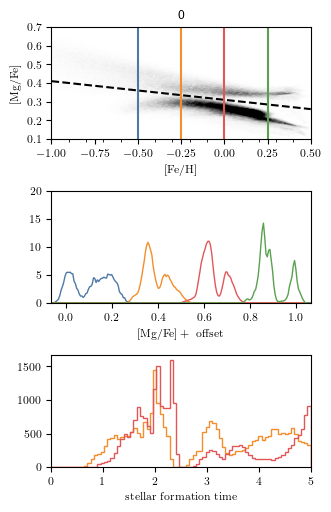

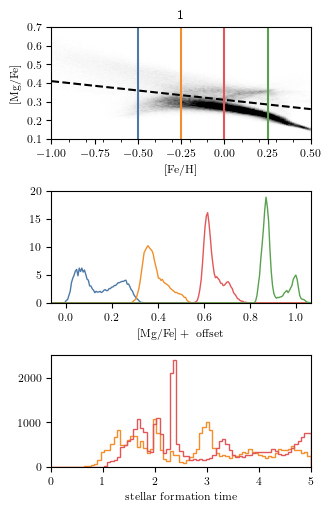

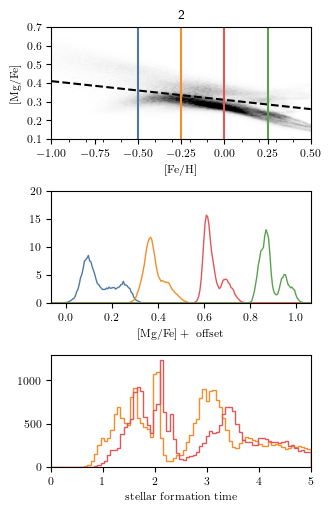

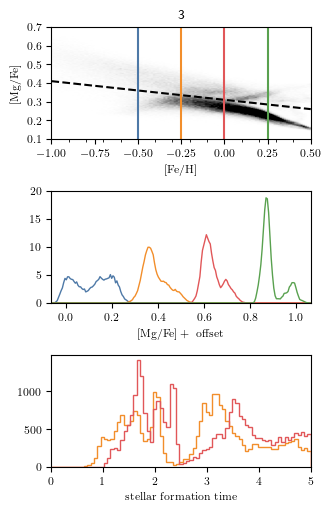

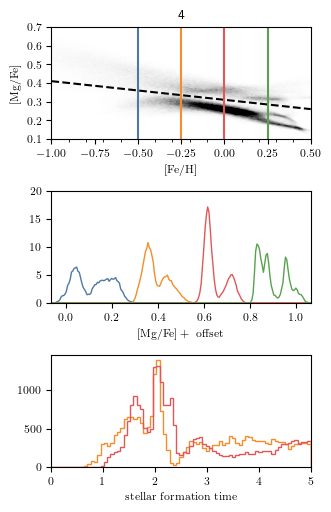

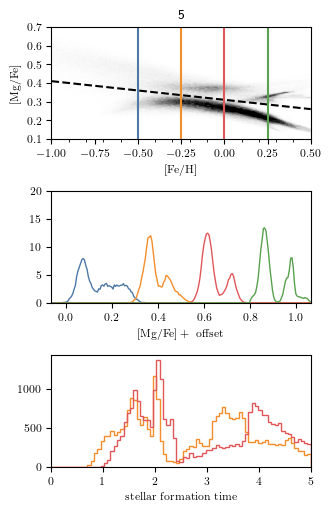

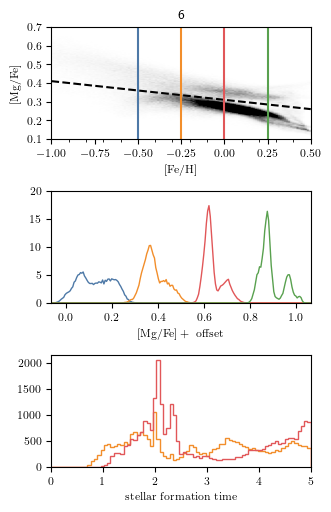

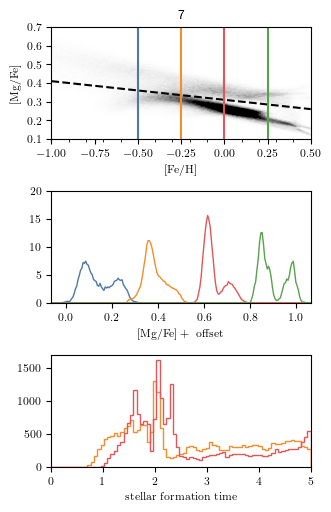

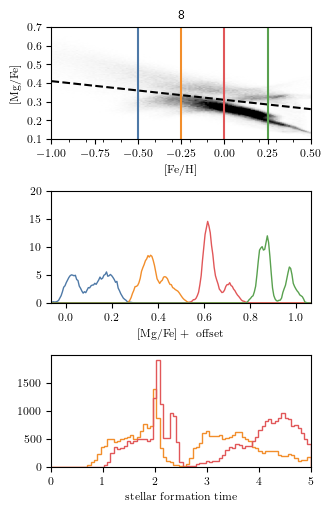

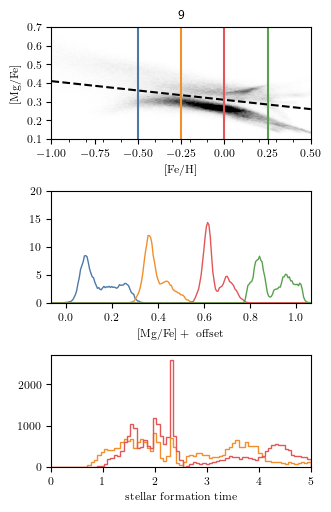

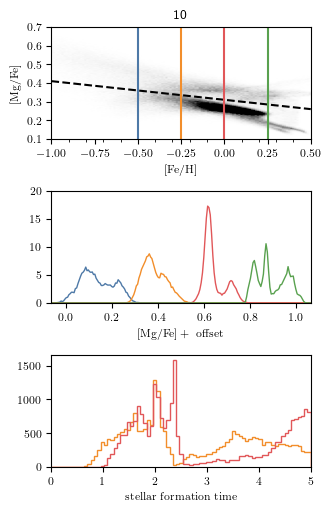

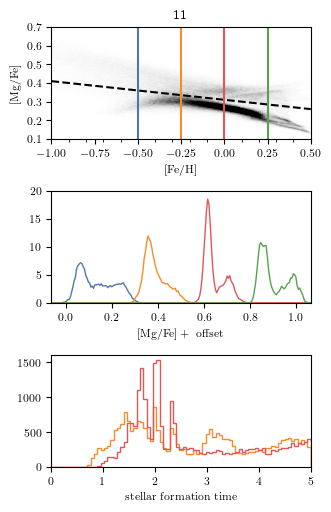

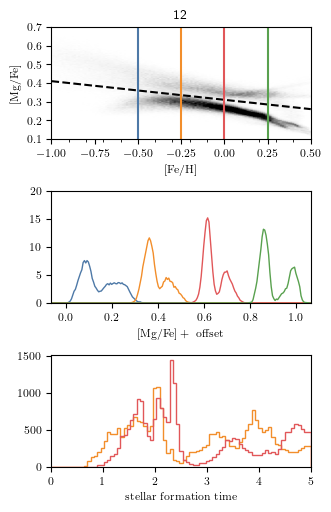

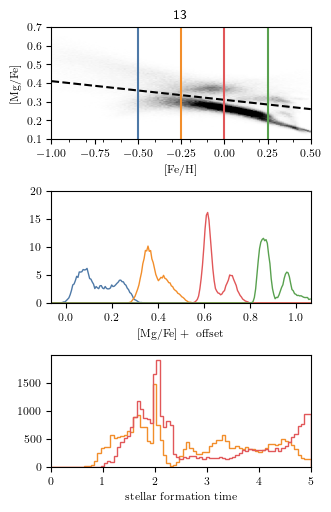

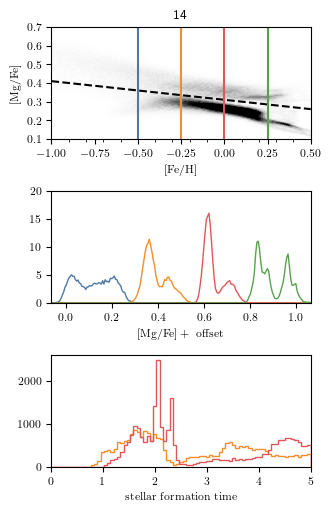

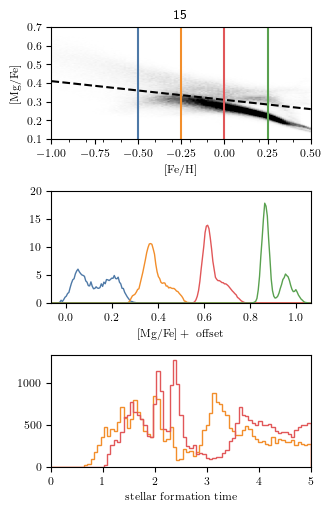

In [302]:
for i in range(16):
    fig, axs = plot_fig1(simdat[i], vmax=5e6)
    axs[0].set_title(str(i))
    
    fig.savefig('fig1/seed'+str(i)+'.pdf')

[(0.1, 0.5499999999999998)]

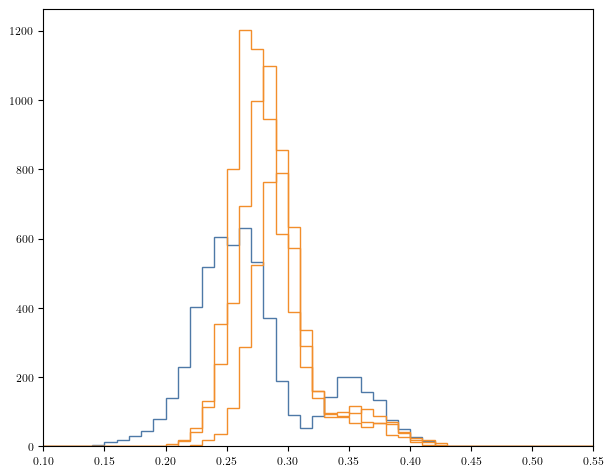

In [173]:
sds = np.arange(4)
logFeH0 = 0
dlogFeH = 0.1

# this is based on plots w/ fiducial sfr
has_bimodal = [0, 4, 7, 12, 13, 14]
sfr_fac = 1

bins = np.arange(0.1, 0.5+0.05, 0.01)
fig, ax = plt.subplots(1, 1, figsize=(textwidth, 0.8*textwidth))
for sd in sds:
    dat = simdat[sd]
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    tform = dat['GFM_StellarFormationTime']
    
    key = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
    wts = np.full_like(logFeH, 1)
    # if sd == 8:
        # wts[tform < 2] = 3
        
    if sd in has_bimodal:
        c = tb_c[0]
    else:
        c = tb_c[1]
    
    ax.hist(logMgFe[key], bins=bins, histtype='step', weights=wts[key], color=c, alpha=1)
    
ax.set(xlim=(bins[0], bins[-1]))

In [229]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.integrate import quad

def construct_gmm(dat, logFeH0=0, dlogFeH=0.2):
    """
    Analyze peaks in the logMgFe data for a given seed number `sd`.

    Parameters:
        simdat (dict): Dictionary containing simulated data.
        sd (int): Seed number for the simulation.
        logFeH0 (float): Central logFeH value to filter data around.
        dlogFeH (float): Range of logFeH to filter data.
        
    Returns:
        peak_heights (list): Heights of each Gaussian peak.
        peak_distance (float): Distance between the centers of the peaks.
    """
    # Extract the data for the given seed
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    
    # Filter data based on logFeH
    key = np.logical_and(logFeH > logFeH0 - dlogFeH / 2, logFeH < logFeH0 + dlogFeH / 2)
    data = logMgFe[key].reshape(-1, 1)

    # Fit a Gaussian Mixture Model
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(data)
    
    return gmm

def calculate_overlap(mean1, std1, mean2, std2):
    """
    Calculate the overlap between two Gaussian distributions.
    
    Parameters:
        mean1, std1: Mean and standard deviation of the first Gaussian.
        mean2, std2: Mean and standard deviation of the second Gaussian.
        
    Returns:
        overlap (float): The overlap between the two distributions.
    """
    def pdf1(x):
        return norm.pdf(x, loc=mean1, scale=std1)
    
    def pdf2(x):
        return norm.pdf(x, loc=mean2, scale=std2)
    
    def min_pdf(x):
        return np.minimum(pdf1(x), pdf2(x))
    
    # Integrate the minimum of the two PDFs
    overlap, _ = quad(min_pdf, -np.inf, np.inf)
    return overlap

def bimodality_metric(gmm):
    """
    Calculate a bimodality metric based on the ratio of the less prominent mode's peak 
    to the trough between the two modes.
    
    Parameters:
        gmm: A fitted GaussianMixture object from sklearn.
    
    Returns:
        bimodality_score (float): The calculated bimodality metric.
    """
    # Extract GMM parameters
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()
    weights = gmm.weights_

    # Ensure components are ordered by mean
    order = np.argsort(means)
    means = means[order]
    variances = variances[order]
    weights = weights[order]

    # Calculate the peaks (heights of the modes)
    peaks = weights / np.sqrt(2 * np.pi * variances)
    less_prominent_peak = min(peaks)

    # Find the trough: point between means where the GMM density is minimized
    x_trough = np.linspace(means[0], means[1], 1000)
    densities = np.exp(gmm.score_samples(x_trough.reshape(-1, 1)))
    trough_density = densities.min()

    # Compute the bimodality metric
    bimodality_score = less_prominent_peak / trough_density
    return bimodality_score

# Example usage:
# Assuming `simdat` is defined and contains the appropriate data
gmm = construct_gmm(simdat[2], logFeH0=0.0, dlogFeH=0.1)
bimodality_metric(gmm)

0.9550749456529523

In [230]:
peak_distance

0.10529856877680338

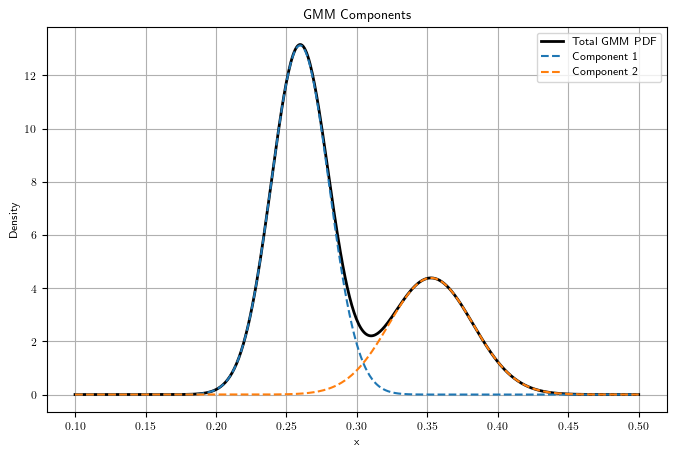

1.9867466857770066


In [303]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def plot_gmm_components(gmm, xrange=(0.1, 0.5), num_points=500):
    """
    Plots the components of a Gaussian Mixture Model over a specified range.
    
    Parameters:
        gmm: A fitted GaussianMixture object from sklearn.
        xrange (tuple): Range of x values for the plot (default: (0.1, 0.5)).
        num_points (int): Number of points to sample in the range (default: 500).
    """
    # Generate x values in the specified range
    x = np.linspace(xrange[0], xrange[1], num_points).reshape(-1, 1)
    
    # Calculate the GMM's total density and individual component densities
    total_density = np.exp(gmm.score_samples(x))
    responsibilities = gmm.predict_proba(x)
    component_densities = responsibilities * total_density[:, np.newaxis]
    
    # Plot the results
    plt.figure(figsize=(8, 5))
    plt.plot(x, total_density, label="Total GMM PDF", linewidth=2, color='black')
    for i, density in enumerate(component_densities.T):
        plt.plot(x, density, linestyle='--', label=f"Component {i+1}")
    
    plt.title("GMM Components")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
# Assuming `gmm` is a fitted GaussianMixture object:
gmm = construct_gmm(simdat[9], logFeH0=0.0, dlogFeH=0.1)
score = bimodality_metric(gmm)
plot_gmm_components(gmm)
print(score)

In [304]:
allgmm = {}
allscore = np.zeros(16)
for sd in np.arange(16):
    allgmm[sd] = construct_gmm(simdat[sd], logFeH0=0.0, dlogFeH=0.1)
    allscore[sd] = bimodality_metric(allgmm[sd])

In [305]:
allscore[has_bimodal]

array([2.39925998, 5.8709892 , 2.39495101, 2.91273134, 3.98338195,
       2.48150245])

In [306]:
not_bimodal = np.full(16, True)
not_bimodal[has_bimodal] = False
allscore[not_bimodal]

array([1.2531785 , 1.59028335, 1.12186921, 3.7168479 , 1.71543664,
       1.54046365, 1.98674669, 3.10746304, 2.44466842, 1.1355906 ])

In [239]:
np.where(not_bimodal)[0][6]

9

In [168]:
allscore[np.argsort(allscore)]

array([0.34160817, 0.36898537, 0.4130601 , 0.46449243, 0.56508695,
       0.65309462, 0.72986587, 0.73821282, 0.80026763, 0.82025058,
       1.08933472, 1.16452867, 1.16932868, 1.32791088, 1.43095689,
       1.80419357])

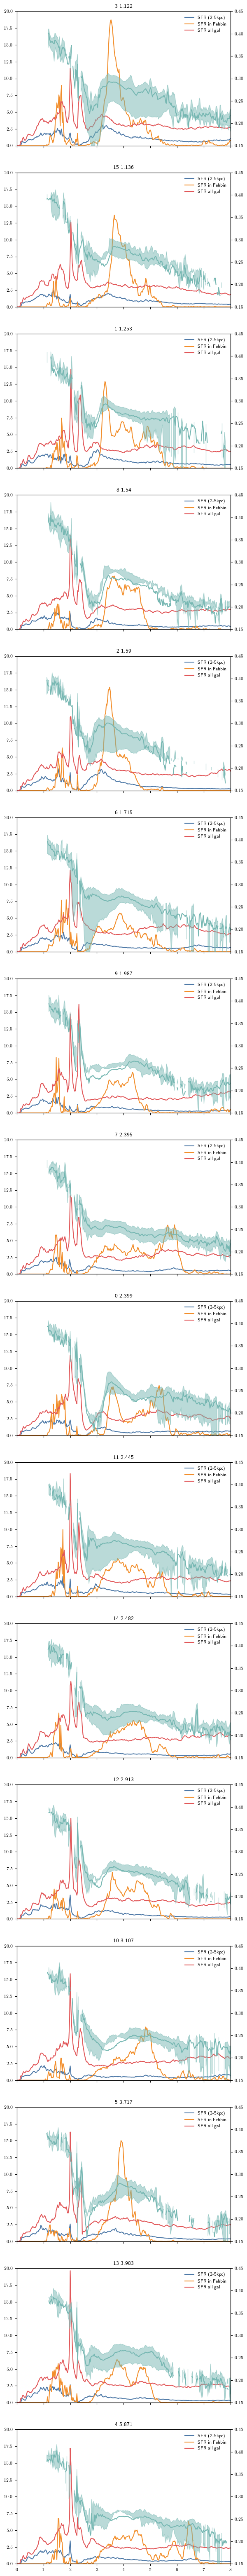

In [307]:
fig, axs = plt.subplots(16, 1, figsize=(2*columnwidth, 2*12*columnwidth), sharex=True, sharey=True)

i_Fe = 10

# this is based on plots w/ fiducial sfr
has_bimodal = [0, 4, 7, 12, 13, 14]
sfr_fac = 1

# this is based on plots w/ enhanced sfr
# has_bimodal = [0, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]
# sfr_fac = 3

for i in alldat.keys():
    sd = np.argsort(allscore)[i]
    
    glob_sfr = np.copy(alldat[sd]['globalSFR'])
    glob_sfr[alldat[sd]['Time'] < 2] *= sfr_fac
    
    sfr = np.copy(alldat[sd]['SFR'])
    sfr[alldat[sd]['Time'] < 2] *= sfr_fac
    
    sfr_inbin = alldat[sd]['SFR_inFeHbin'][:,i_Fe]/0.05
    sfr_inbin[alldat[sd]['Time'] < 2] *= sfr_fac
    
    axs[i].plot(alldat[sd]['Time'], sfr, c=tb_c[0], label='SFR (2-5kpc)')
    # axs[i].plot(alldat[sd]['Time'], alldat[sd]['Mgas']/alldat[i]['SFR'], c=tb_c[2])
    axs[i].plot(alldat[sd]['Time'], sfr_inbin, c=tb_c[1], label='SFR in Fehbin')
    axs[i].plot(alldat[sd]['Time'], glob_sfr, c=tb_c[2], label='SFR all gal')
    
    ax2 = axs[i].twinx()
    ax2.set(ylim=(0.15, 0.45))
    
    ax2.plot(alldat[i]['Time'], alldat[sd]['medalpha_inFeHbin'][:,i_Fe], c=tb_c[3], label='med alpha in bin')
    ax2.fill_between(alldat[sd]['Time'], alldat[i]['loperc_alpha_inFeHbin'][:,i_Fe], 
                     alldat[sd]['hiperc_alpha_inFeHbin'][:,i_Fe], color=tb_c[3], alpha=0.5)
    
    # if i in has_bimodal:
        # axs[i].set_title(str(i)+' bimodal')
    # else:
        # axs[i].set_title(str(i)+' unimodal')        
    axs[i].set_title(str(sd)+'   '+str(round(allscore[sd], 3)))
    axs[i].legend(frameon=False)
    
axs[0].set(xlim=(0, 8), ylim=(0, 20))

fig.savefig('sfh_stuff.png')
fig.savefig('sfh_stuff2.pdf')

In [ ]:
# histogram of alpha in feh bin in 3-4 Gyr
# histogra of alpha in feh bin in 1-2 Gyr


100%|██████████| 16/16 [00:00<00:00, 98.03it/s] 


(0.0, 2250.0)


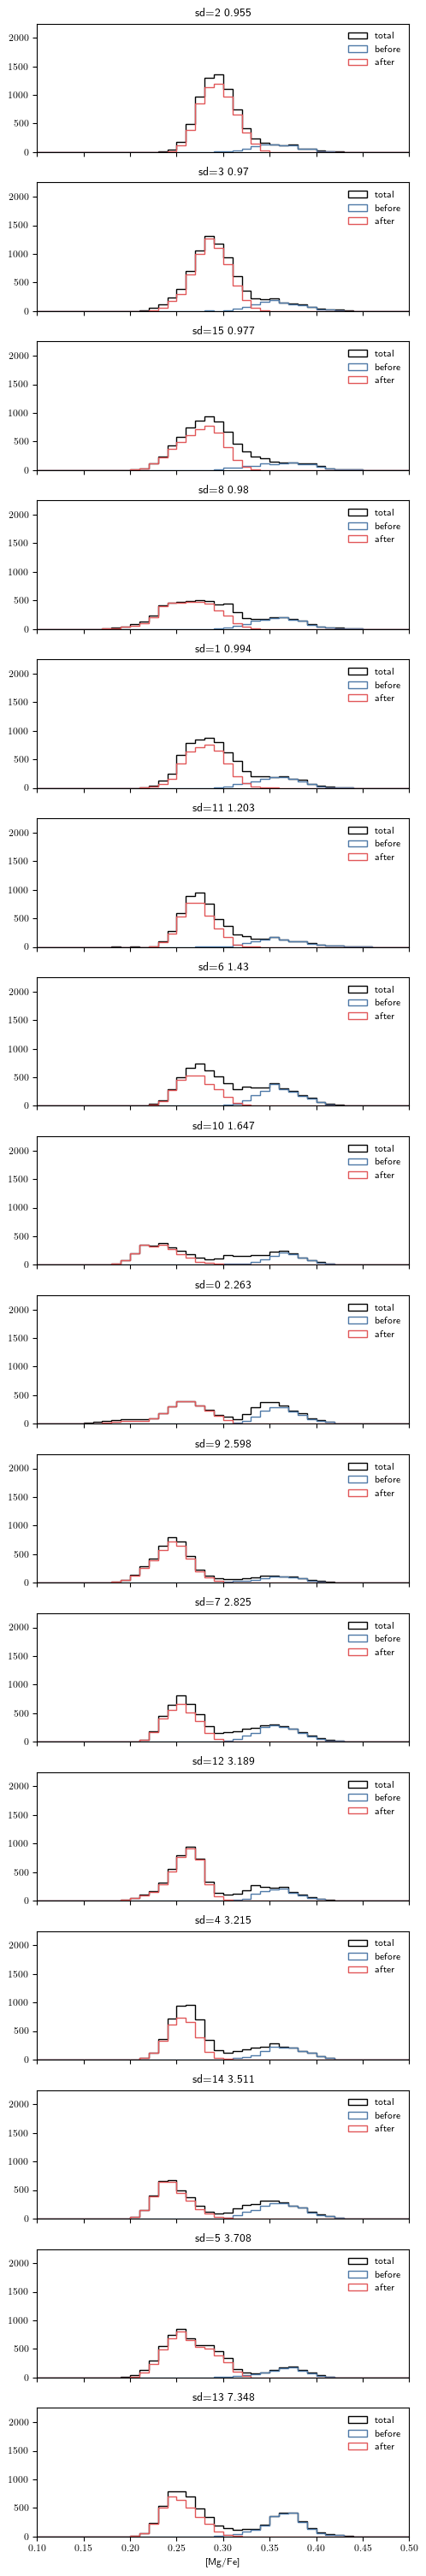

In [260]:
fig, axs = plt.subplots(16, 1, figsize=(1.5*columnwidth, 9*columnwidth), sharex=True, sharey=True)

logFeH0 = 0.
dlogFeH = 0.2

bins = np.arange(0.1, 0.5+0.01, 0.01)

for i,ax in enumerate(tqdm(axs)):
    sd = np.argsort(allscore)[i]
    
    dat = simdat[sd]
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    tform = dat['GFM_StellarFormationTime']
    
    key = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
    key = np.logical_and(key, tform < 4)
    
    key_before = np.logical_and(key, np.logical_and(tform > 1.2, tform < 2.2))
    key_during = np.logical_and(key, np.logical_and(tform > 2, tform < 3))
    key_after  = np.logical_and(key, np.logical_and(tform > 3, tform < 4))
    
    ax.hist(logMgFe[key],        histtype='step', color='k', bins=bins, label='total')
    ax.hist(logMgFe[key_before], histtype='step', color=tb_c[0], bins=bins, label='before')
    # ax.hist(logMgFe[key_during],  histtype='step', color=tb_c[1], bins=bins, label='during')
    ax.hist(logMgFe[key_after],  histtype='step', color=tb_c[2], bins=bins, label='after')
    ax.legend(frameon=False)
    ax.set_title('sd='+str(sd)+'  '+str(round(allscore[sd], 3)))
    
    
    
axs[0].set(xlim=(bins[0], bins[-1]), ylim=(0, 2250))
axs[-1].set(xlabel='[Mg/Fe]')

print(axs[0].get_ylim())

fig.tight_layout()
fig.savefig('MgFe_beforeafter.png')

In [191]:
# try unimodal

In [192]:
def load_galaxy_bysim(sim, idx=320):
    Rs, Vv, ecc = sim
    key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
    return galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)

In [194]:
gal_uni = load_galaxy_bysim(('129', '116', '04'))
simdat_uni = extract_sim_data(gal_uni)

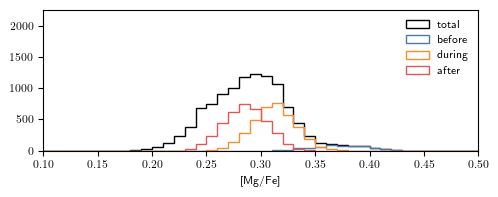

In [203]:
fig, ax = plt.subplots(1, 1, figsize=(1.5*columnwidth, 0.6*columnwidth), sharex=True, sharey=True)

logFeH0 = 0.
dlogFeH = 0.2

bins = np.arange(0.1, 0.5+0.01, 0.01)

# for i,ax in enumerate(tqdm(axs)):
if True:
    dat = simdat_uni
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    tform = dat['GFM_StellarFormationTime']
    
    key = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
    # key = np.logical_and(key, tform < 5)
    key_before = np.logical_and(key, np.logical_and(tform > 1, tform < 2))
    key_during = np.logical_and(key, np.logical_and(tform > 2, tform < 3))
    key_after  = np.logical_and(key, np.logical_and(tform > 3, tform < 4))
    
    ax.hist(logMgFe[key],        histtype='step', color='k', bins=bins, label='total')
    ax.hist(logMgFe[key_before], histtype='step', color=tb_c[0], bins=bins, label='before')
    ax.hist(logMgFe[key_during],  histtype='step', color=tb_c[1], bins=bins, label='during')
    ax.hist(logMgFe[key_after],  histtype='step', color=tb_c[2], bins=bins, label='after')
    ax.legend(frameon=False)
    
ax.set(xlim=(bins[0], bins[-1]), ylim=(0, 2250))
ax.set(xlabel='[Mg/Fe]')

fig.tight_layout()
# fig.savefig('MgFe_beforeafter.png')

In [204]:
import numpy as np

def average_logMgFe(dat, logFeH0, dlogFeH):
    """
    Computes the average logMgFe as a function of tform in bins of tform.

    Parameters:
        dat (dict): Dictionary containing 'logFeH', 'logMgFe', and 'GFM_StellarFormationTime'.
        logFeH0 (float): Center of the logFeH range for selection.
        dlogFeH (float): Width of the logFeH range for selection.

    Returns:
        tuple: Arrays of bin centers and average logMgFe values in each bin.
    """
    # Extract the required data
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    tform = dat['GFM_StellarFormationTime']
    
    # Define the selection key
    key = np.logical_and(logFeH > logFeH0 - dlogFeH / 2., logFeH < logFeH0 + dlogFeH / 2.)
    
    # Filter the data using the key
    selected_logMgFe = logMgFe[key]
    selected_tform = tform[key]
    
    # Define bins for tform
    bins = np.arange(0, 8.1, 0.1)  # Bins from 0 to 8 with width 0.1
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Compute average logMgFe in each tform bin
    avg_logMgFe = []
    for i in range(len(bins) - 1):
        in_bin = np.logical_and(selected_tform >= bins[i], selected_tform < bins[i+1])
        if np.any(in_bin):  # Avoid division by zero
            avg_logMgFe.append(np.mean(selected_logMgFe[in_bin]))
        else:
            avg_logMgFe.append(np.nan)  # Handle empty bins
    
    return bin_centers, np.array(avg_logMgFe)

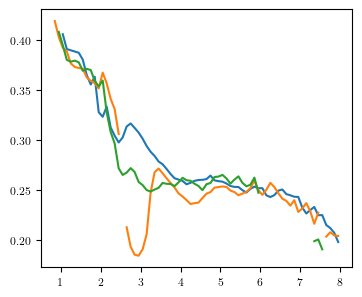

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(1.2*columnwidth, columnwidth))

dat = simdat_uni
tplot, ave_logMgFe = average_logMgFe(dat, 0, 0.2)
ax.plot(tplot, ave_logMgFe)

dat = simdat[0]
tplot, ave_logMgFe = average_logMgFe(dat, 0, 0.2)
ax.plot(tplot, ave_logMgFe)

dat = simdat[13]
tplot, ave_logMgFe = average_logMgFe(dat, 0, 0.2)
ax.plot(tplot, ave_logMgFe)

In [242]:
allscore

array([2.2633666 , 0.99371277, 0.95507495, 0.97033037, 3.21486923,
       3.70849653, 1.43005041, 2.82485102, 0.97986842, 2.59772761,
       1.64665337, 1.20299349, 3.18897635, 7.34809158, 3.5109811 ,
       0.97724522])


100%|██████████| 16/16 [00:00<00:00, 106.89it/s]


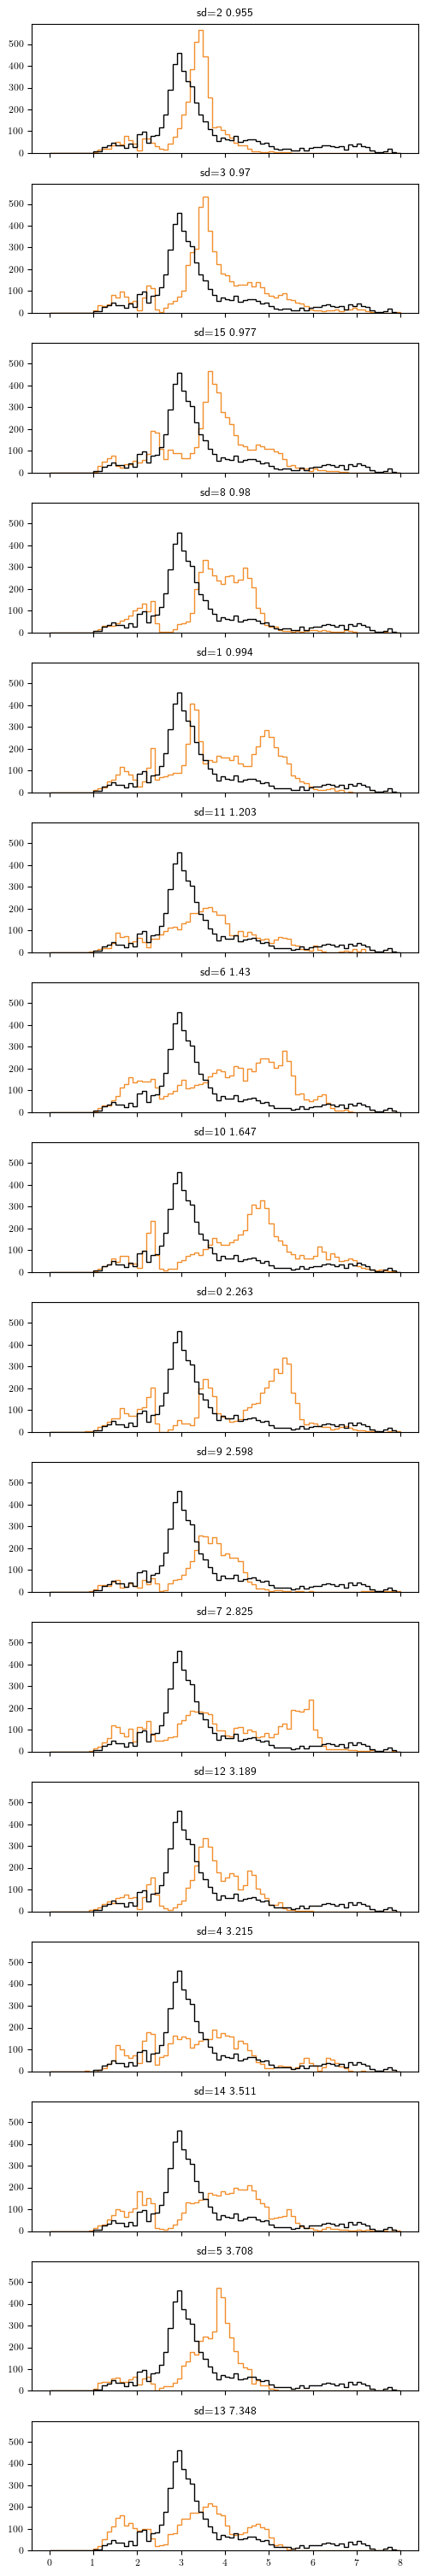

In [243]:
fig, axs = plt.subplots(16, 1, figsize=(1.5*columnwidth, 9*columnwidth), sharex=True, sharey=True)

logFeH0 = 0.
dlogFeH = 0.1

tbins = np.arange(0, 8+0.1, 0.1)

for i,ax in enumerate(tqdm(axs)):
    sd = np.argsort(allscore)[i]
    
    dat = simdat[sd]
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    tform = dat['GFM_StellarFormationTime']
    
    key = np.logical_and(logFeH > logFeH0 - dlogFeH / 2., logFeH < logFeH0 + dlogFeH / 2.)
    ax.hist(tform[key], bins=tbins, histtype='step', color=tb_c[1])
    
    dat = simdat_uni
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    tform = dat['GFM_StellarFormationTime']
    
    key = np.logical_and(logFeH > logFeH0 - dlogFeH / 2., logFeH < logFeH0 + dlogFeH / 2.)
    ax.hist(tform[key], bins=tbins, histtype='step', color='k')
    
    ax.set_title('sd='+str(sd)+'  '+str(round(allscore[sd], 3)))
    
fig.tight_layout()

# alpha/Fe - Fe/H plane movie

In [268]:
def plot_fig1(data, vmax=4e5):
    fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.8*columnwidth))
    
    logFeH_lim  = (-1, 0.5)
    logMgFe_lim = (0.1, 0.65)

    N_FeH = 125
    N_MgFe = 125
    
    logFeH = data['logFeH']
    logMgFe = data['logMgFe']
    tform = data['GFM_StellarFormationTime']
    
    FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
    MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
    dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
    dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
        
    wts = np.ones(len(logFeH))/dFeH/dMgFe
    H, _, _, _ = binned_statistic_2d(logFeH, logMgFe, wts, statistic='sum', bins=[FeH_bins, MgFe_bins])

    extent = [logFeH_lim[0], logFeH_lim[1], logMgFe_lim[0], logMgFe_lim[1]]
    im = ax.imshow(H.T, origin='lower', extent=extent, cmap='Greys', vmin=0, vmax=vmax)
    
    ax.set(xlim=logFeH_lim, ylim=logMgFe_lim)
    ax.set(xlabel=r'$[\textrm{Fe}/\textrm{H}]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}]$')
    ax.set(aspect='auto')
    
    axs[0].set_xticks(np.arange(-1, 0.5+0.1, 0.1), minor=True)
    axs[0].set_yticks(np.arange(0.1, 0.7+0.1, 0.1))
    
    fig.tight_layout()
    
    return fig, ax

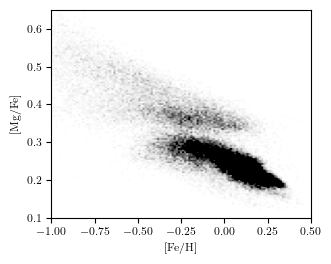

In [269]:
fig, ax = plot_fig1(simdat[0])

In [294]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import binned_statistic_2d

def plot_fig1(data, vmax=1e5):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4.8))  # Adjust figure size as needed
    
    logFeH_lim  = (-1, 0.5)
    logMgFe_lim = (0.1, 0.65)

    N_FeH = 75
    N_MgFe = 75
    
    logFeH = data['logFeH']
    logMgFe = data['logMgFe']
    
    FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
    MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
    dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
    dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
        
    wts = np.ones(len(logFeH))/dFeH/dMgFe
    H, _, _, _ = binned_statistic_2d(logFeH, logMgFe, wts, statistic='sum', bins=[FeH_bins, MgFe_bins])

    extent = [logFeH_lim[0], logFeH_lim[1], logMgFe_lim[0], logMgFe_lim[1]]
    im = ax.imshow(H.T, origin='lower', extent=extent, cmap='Greys', vmin=0, vmax=vmax)
    
    ax.set(xlim=logFeH_lim, ylim=logMgFe_lim)
    # ax.set(xlabel=r'$[\textrm{Fe}/\textrm{H}]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}]$')
    ax.set(aspect='auto')
    ax.set_xticks(np.arange(-1, 0.6, 0.1), minor=True)
    ax.set_yticks(np.arange(0.1, 0.8, 0.1))
    
    fig.tight_layout()
    
    return fig, ax, im

def make_movie(data, filename='tform_movie.mp4', fps=8, title=None):
    # Parameters
    tform = data['GFM_StellarFormationTime']
    tform_bins = np.arange(0, 8.025, 0.05)  # tform from 0 to 8, steps of 0.05
    bin_width = 0.1  # Each frame shows a bin width of 0.1

    fig, ax, im = plot_fig1(data)
    time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, color='red', ha='left', va='top')
    if title is not None:
        ax.set_title(title)
    
    # add line separating the two sequences
    x = np.linspace(-1, 0.5, 1000)
    y = -0.1*x + 0.31
    ax.plot(x, y, c='k', ls='dashed')

    def update(frame):
        # Define tform range for this frame
        tform_min = tform_bins[frame]
        tform_max = tform_min + bin_width
        time_text.set_text(r'${:.2f} \leq \mathrm{{tform}} < {:.2f}$'.format(tform_min, tform_max))

        # Mask data based on tform range
        mask = np.logical_and(tform >= tform_min, tform < tform_max)
        masked_logFeH = data['logFeH'][mask]
        masked_logMgFe = data['logMgFe'][mask]
    
        # Create 2D histogram for masked data
        FeH_bins = np.linspace(-1, 0.5, 126)
        MgFe_bins = np.linspace(0.1, 0.65, 126)
        dFeH = 1.5 / 125
        dMgFe = 0.55 / 125
    
        if len(masked_logFeH) > 0:
            wts = np.ones(len(masked_logFeH)) / dFeH / dMgFe
            H, _, _, _ = binned_statistic_2d(
                masked_logFeH, masked_logMgFe, wts, statistic='sum', bins=[FeH_bins, MgFe_bins]
            )
        else:
            H = np.zeros((125, 125))
    
        # Update image
        im.set_data(H.T)
        return im, time_text


    # Create animation
    num_frames = len(tform_bins) - 1
    # num_frames = 80
    if 'seed0' in title:
        itr = tqdm(np.arange(num_frames), position=0, leave=True)
    else:
        itr = np.arange(num_frames)
    anim = FuncAnimation(fig, update, itr, blit=True)

    # Save as video
    anim.save(filename, writer='ffmpeg', fps=fps)
    plt.close(fig)


In [295]:
Parallel(n_jobs=16)(delayed(make_movie)(simdat[sd], title='seed'+str(sd)+'  '+str(round(allscore[sd],3)),
                                        filename='tform_movie/tform_movie_seed'+str(sd)+'.mp4', 
                                        fps=8) for sd in range(16))

 99%|█████████▉| 158/160 [00:16<00:00,  9.84it/s]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [287]:
for sd in np.argsort(allscore):
    print(sd, allscore[sd])

2 0.9550749456529523
3 0.9703303681576784
15 0.9772452224023096
8 0.9798684161983926
1 0.9937127734883932
11 1.2029934855228865
6 1.4300504130934109
10 1.6466533721331276
0 2.263366604426497
9 2.5977276113025534
7 2.824851015183447
12 3.1889763494540615
4 3.2148692291548167
14 3.5109811026338025
5 3.7084965348953793
13 7.348091576754982
